In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import time

np.random.seed(42)

file_path = "/content/diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['Diabetes_012'].value_counts()}")


Dataset shape: (253680, 22)
Target distribution:
Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


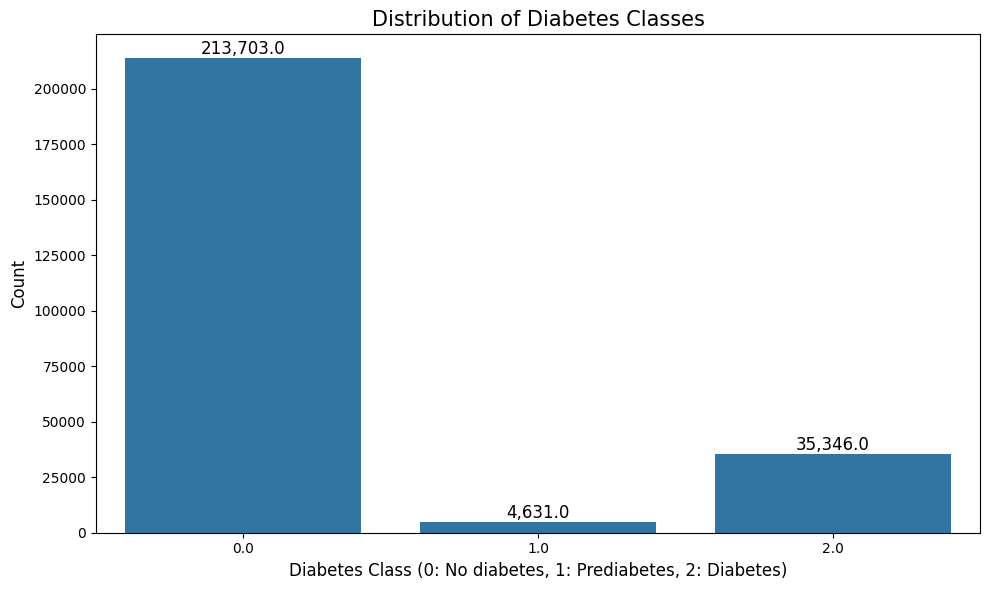

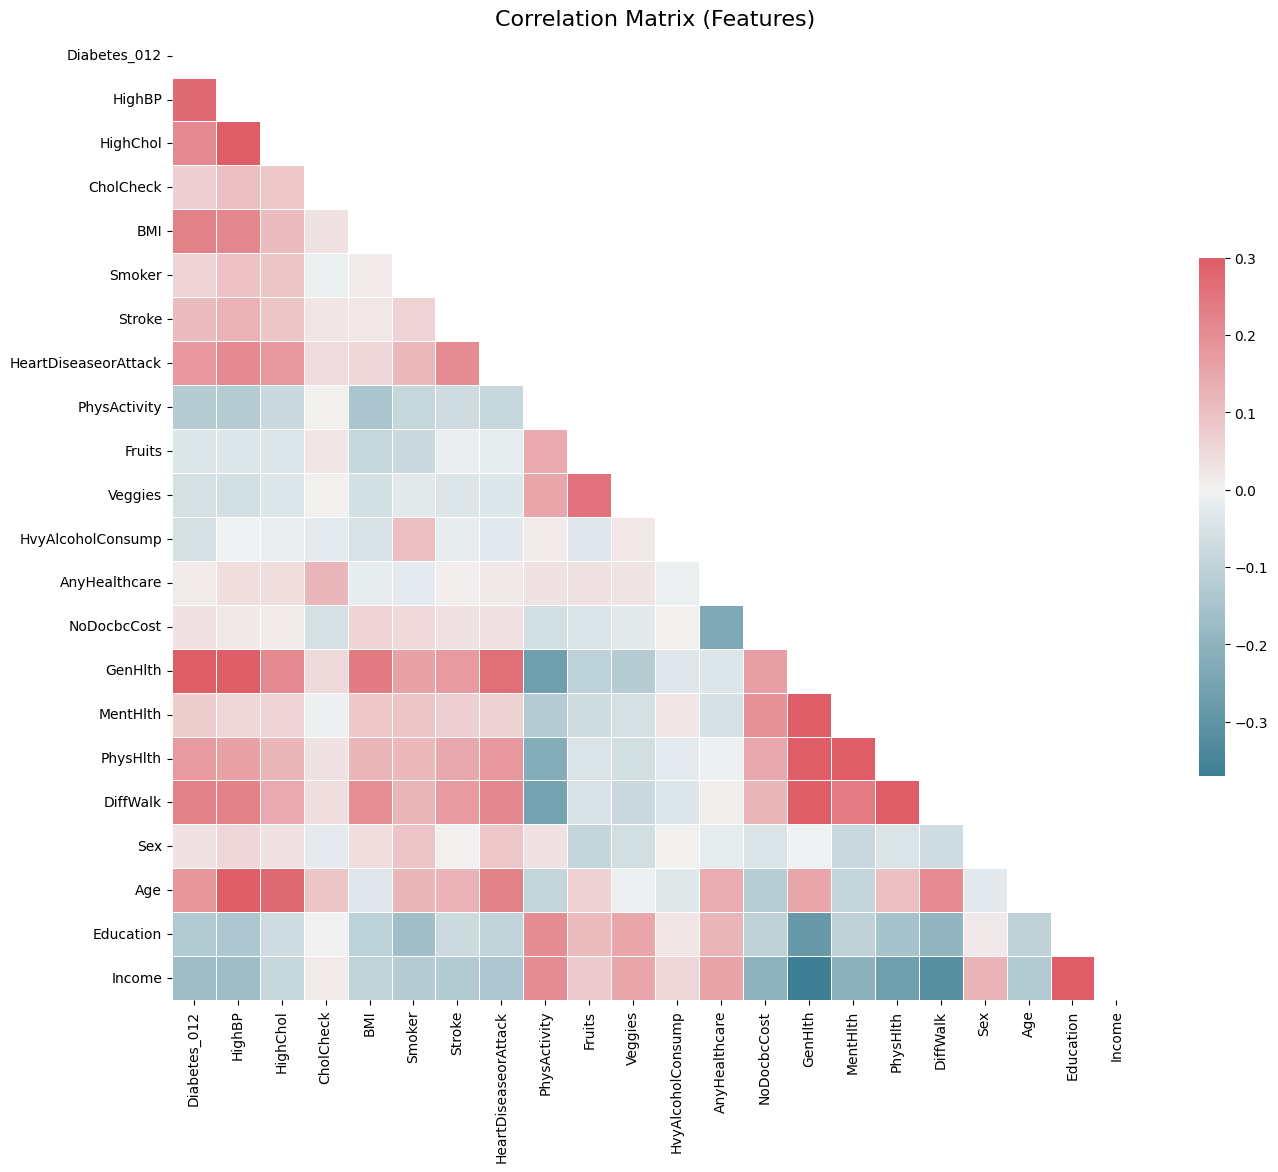


--- Multicollinearity Analysis ---
Highly correlated feature pairs (potential multicollinearity):
PhysHlth and GenHlth: 0.524

Variance Inflation Factor (VIF) Analysis:
                 feature        VIF
19             Education  29.507416
2              CholCheck  23.187436
11         AnyHealthcare  20.839710
3                    BMI  18.149913
20                Income  14.156118
13               GenHlth  10.740162
18                   Age   9.886830
9                Veggies   5.826886
7           PhysActivity   4.645314
8                 Fruits   3.032775
0                 HighBP   2.299761
1               HighChol   2.029660
15              PhysHlth   1.999556
4                 Smoker   1.933042
17                   Sex   1.910708
16              DiffWalk   1.838551
14              MentHlth   1.463103
6   HeartDiseaseorAttack   1.289820
12           NoDocbcCost   1.215834
5                 Stroke   1.126777
10     HvyAlcoholConsump   1.083523


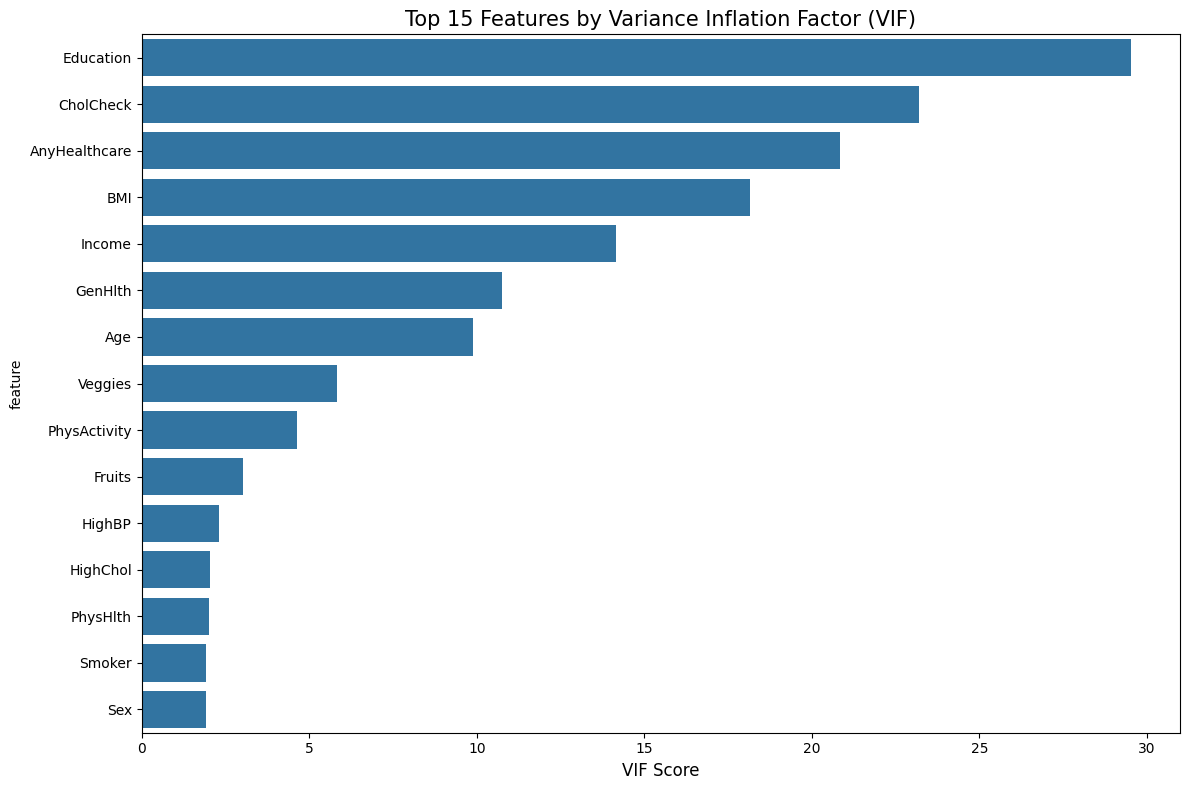

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -------------------- DATA VISUALIZATION --------------------

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Diabetes_012', data=df)
plt.title('Distribution of Diabetes Classes', fontsize=15)
plt.xlabel('Diabetes Class (0: No diabetes, 1: Prediabetes, 2: Diabetes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('class_distribution_enhanced.png')
plt.show()
plt.close()

# -------------------- MULTICOLLINEARITY ANALYSIS --------------------

correlation_matrix = df.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=False, fmt='.2f', cbar_kws={"shrink": .5})
plt.title('Correlation Matrix (Features)', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png')  # ✅ Corrected
plt.show()
plt.close()

print("\n--- Multicollinearity Analysis ---")
high_corr_threshold = 0.5
high_corr_features = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if col_i != 'Diabetes_012' and col_j != 'Diabetes_012':
                high_corr_features.append((col_i, col_j, correlation))

high_corr_features.sort(key=lambda x: abs(x[2]), reverse=True)

if high_corr_features:
    print("Highly correlated feature pairs (potential multicollinearity):")
    for col_i, col_j, corr in high_corr_features:
        print(f"{col_i} and {col_j}: {corr:.3f}")
else:
    print("No high correlations found between features (threshold = 0.5)")

X_vif = df.drop('Diabetes_012', axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)

print("\nVariance Inflation Factor (VIF) Analysis:")
print(vif_data)

# Create VIF visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='VIF', y='feature', data=vif_data.head(15))
plt.title('Top 15 Features by Variance Inflation Factor (VIF)', fontsize=15)
plt.xlabel('VIF Score', fontsize=12)
plt.tight_layout()
plt.savefig('vif_analysis.png')
plt.show()
plt.close()


Feature Correlation with Target (Diabetes_012):
GenHlth                 0.302587
HighBP                  0.271596
BMI                     0.224379
DiffWalk                0.224239
HighChol                0.209085
Age                     0.185026
HeartDiseaseorAttack    0.180272
PhysHlth                0.176287
Stroke                  0.107179
MentHlth                0.073507
Name: Diabetes_012, dtype: float64


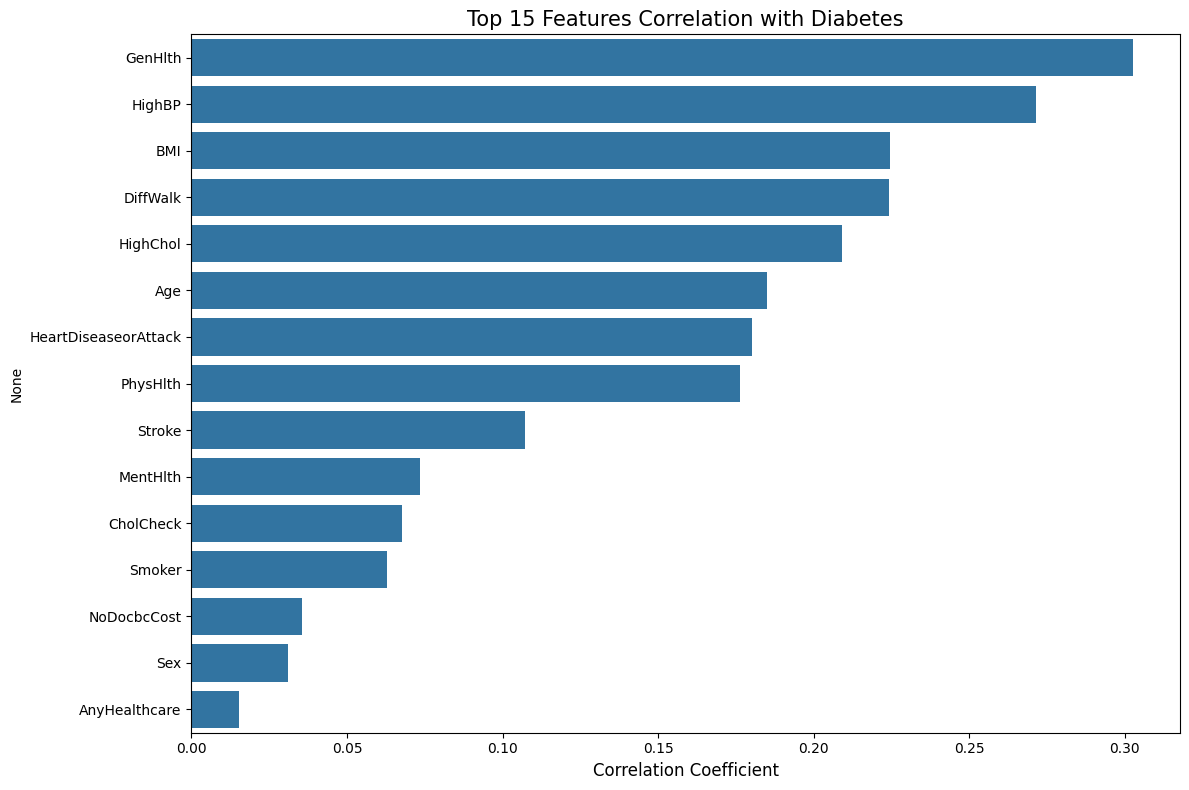

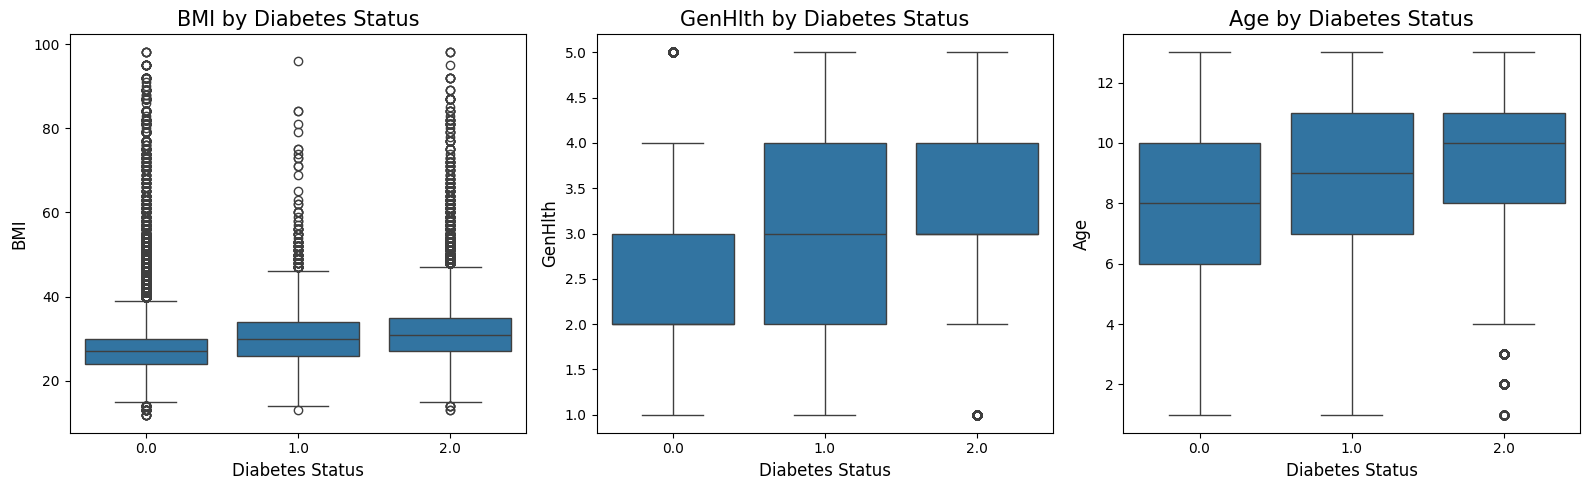

<Figure size 1000x600 with 0 Axes>

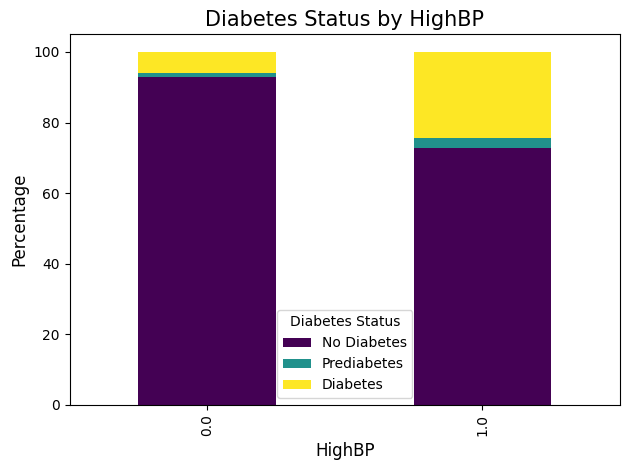

<Figure size 1000x600 with 0 Axes>

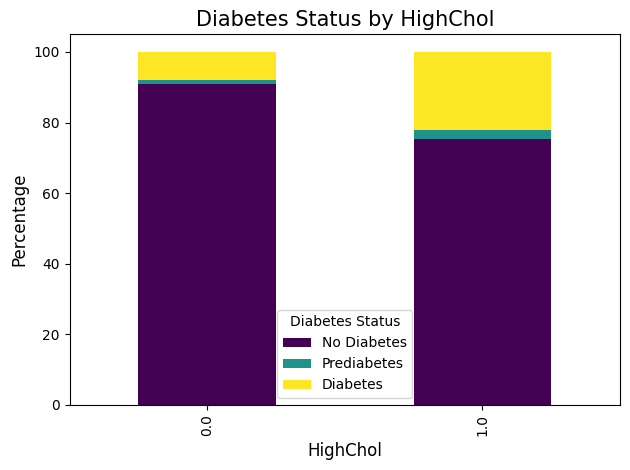

<Figure size 1000x600 with 0 Axes>

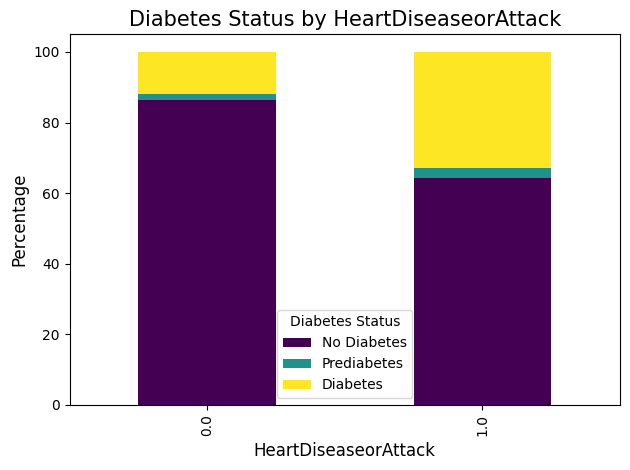

In [6]:
# -------------------- FEATURE CORRELATION WITH TARGET --------------------


corr_with_target = correlation_matrix['Diabetes_012'].drop('Diabetes_012').sort_values(ascending=False)
print("\nFeature Correlation with Target (Diabetes_012):")
print(corr_with_target.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x=corr_with_target.head(15).values, y=corr_with_target.head(15).index)
plt.title('Top 15 Features Correlation with Diabetes', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.tight_layout()
plt.savefig('target_correlation.png')
plt.show()
plt.close()

# -------------------- VISUALIZE TOP FEATURES --------------------

# Scatter plots for top 3 continuous variables
top_continuous = ['BMI', 'GenHlth', 'Age']

plt.figure(figsize=(16, 5))
for i, feature in enumerate(top_continuous):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='Diabetes_012', y=feature, data=df)
    plt.title(f'{feature} by Diabetes Status', fontsize=15)
    plt.xlabel('Diabetes Status', fontsize=12)
    plt.ylabel(feature, fontsize=12)
plt.tight_layout()
plt.savefig('top_features_boxplot.png')
plt.show()
plt.close()

top_categorical = ['HighBP', 'HighChol', 'HeartDiseaseorAttack']

def create_stacked_bar(feature):

    ctab = pd.crosstab(df[feature], df['Diabetes_012'])

    ctab_pct = ctab.div(ctab.sum(axis=1), axis=0) * 100


    plt.figure(figsize=(10, 6))
    ctab_pct.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Diabetes Status by {feature}', fontsize=15)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
    plt.tight_layout()
    plt.savefig(f'stacked_bar_{feature}.png')
    plt.show()
    plt.close()

for feature in top_categorical:
    create_stacked_bar(feature)


In [ ]:

# -------------------- DATA PREPARATION --------------------


X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']
feature_names = X.columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------- MODEL COMPARISON --------------------


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
}

def evaluate_model(model, name, X_train, X_test, y_train, y_test):

    start_time = time.time()

    model.fit(X_train, y_train)


    train_time = time.time() - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Training Time (s)': train_time,
        'Trained Model': model
    }

print("\n--- Model Comparison ---")
results = []

for name, model in models.items():
    print(f"Training {name}...")
    result = evaluate_model(model, name, X_train_scaled, X_test_scaled, y_train, y_test)
    results.append(result)
    print(f"{name} - Accuracy: {result['Accuracy']:.4f}, F1: {result['F1 Score']:.4f}, Time: {result['Training Time (s)']:.2f}s")

performance_df = pd.DataFrame(results)
performance_df = performance_df.sort_values('Accuracy', ascending=False)
performance_table = performance_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)']]

print("\nModel Performance Comparison:")
print(performance_table)

plt.figure(figsize=(12, 8))
performance_metrics = performance_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
performance_metrics = performance_metrics.set_index('Model')
performance_metrics.plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison', fontsize=15)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.close()

best_model_name = performance_df.iloc[0]['Model']
best_model = performance_df.iloc[0]['Trained Model']
print(f"\nBest Model: {best_model_name} with accuracy {performance_df.iloc[0]['Accuracy']:.4f}")

# -------------------- XAI METHODS COMPARISON --------------------

print("\n--- XAI Methods Comparison ---")

feature_importance_rankings = {}

print("Calculating Permutation Importance...")
start_time = time.time()
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=5, random_state=42)
perm_time = time.time() - start_time

perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
})
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)

feature_importance_rankings['Permutation Importance'] = perm_importance_df['Feature'].tolist()

print(f"Top 10 features by Permutation Importance (time: {perm_time:.2f}s):")
print(perm_importance_df.head(10))

if isinstance(best_model, LogisticRegression):
    print("\nCalculating Coefficient-based Importance...")
    start_time = time.time()

    if len(best_model.classes_) > 2:
        coef = np.mean(np.abs(best_model.coef_), axis=0)
    else:
        coef = np.abs(best_model.coef_[0])

    coef_time = time.time() - start_time

    coef_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coef
    })
    coef_importance_df = coef_importance_df.sort_values('Importance', ascending=False)

    feature_importance_rankings['Coefficient Importance'] = coef_importance_df['Feature'].tolist()

    print(f"Top 10 features by Coefficient Importance (time: {coef_time:.2f}s):")
    print(coef_importance_df.head(10))

if isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier)):
    print("\nCalculating Tree-based Feature Importance...")
    start_time = time.time()

    tree_importance = best_model.feature_importances_
    tree_time = time.time() - start_time

    tree_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': tree_importance
    })
    tree_importance_df = tree_importance_df.sort_values('Importance', ascending=False)

    feature_importance_rankings['Tree-based Importance'] = tree_importance_df['Feature'].tolist()

    print(f"Top 10 features by Tree-based Importance (time: {tree_time:.2f}s):")
    print(tree_importance_df.head(10))

if len(feature_importance_rankings) > 1:
    print("\n--- XAI Methods Consistency Analysis ---")

    def rank_correlation(method1, method2):

        common_features = set(feature_importance_rankings[method1]) & set(feature_importance_rankings[method2])

        rank1 = {feature: i for i, feature in enumerate(feature_importance_rankings[method1])}
        rank2 = {feature: i for i, feature in enumerate(feature_importance_rankings[method2])}

        common_rank1 = [rank1[feature] for feature in common_features]
        common_rank2 = [rank2[feature] for feature in common_features]

        from scipy.stats import spearmanr
        correlation, pvalue = spearmanr(common_rank1, common_rank2)

        return correlation, pvalue

    methods = list(feature_importance_rankings.keys())
    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1 = methods[i]
            method2 = methods[j]
            correlation, pvalue = rank_correlation(method1, method2)
            print(f"Rank correlation between {method1} and {method2}: {correlation:.3f} (p-value: {pvalue:.3f})")

    top_features_count = {}
    for method, ranking in feature_importance_rankings.items():
        for feature in ranking[:10]:
            if feature in top_features_count:
                top_features_count[feature] += 1
            else:
                top_features_count[feature] = 1

    consensus_features = sorted(top_features_count.items(), key=lambda x: x[1], reverse=True)

    print("\nConsensus top features across all XAI methods:")
    for feature, count in consensus_features:
        print(f"{feature}: appears in {count}/{len(methods)} methods")

plt.figure(figsize=(12, 8))

if isinstance(best_model, LogisticRegression):
    sns.barplot(x='Importance', y='Feature', data=coef_importance_df.head(15))
    plt.title(f'Top 15 Features by Coefficient Importance ({best_model_name})', fontsize=15)
elif isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier)):
    sns.barplot(x='Importance', y='Feature', data=tree_importance_df.head(15))
    plt.title(f'Top 15 Features by Tree-based Importance ({best_model_name})', fontsize=15)
else:
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15))
    plt.title(f'Top 15 Features by Permutation Importance ({best_model_name})', fontsize=15)

plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.savefig('best_model_feature_importance.png')
plt.close()




--- Model Comparison ---
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression - Accuracy: 0.8455, F1: 0.8069, Time: 1.67s
Training Decision Tree...
Decision Tree - Accuracy: 0.8454, F1: 0.8105, Time: 1.42s
Training Random Forest...


In [11]:
# -------------------- SUMMARY --------------------

print("\n--- Summary ---")
print(f"1. Best performing model: {best_model_name}")
print(f"2. Multicollinearity identified between {len(high_corr_features)} feature pairs")
print(f"3. Most important features from the best model's XAI method:")

if isinstance(best_model, LogisticRegression):
    top_features = coef_importance_df['Feature'].head(5).tolist()
    best_xai = "Coefficient Importance"
elif isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier)):
    top_features = tree_importance_df['Feature'].head(5).tolist()
    best_xai = "Tree-based Importance"
else:
    top_features = perm_importance_df['Feature'].head(5).tolist()
    best_xai = "Permutation Importance"

for i, feature in enumerate(top_features):
    print(f"   {i+1}. {feature}")

print(f"\nBest XAI method for this model: {best_xai}")
print("Analysis completed successfully!")


--- Summary ---
1. Best performing model: Logistic Regression
2. Multicollinearity identified between 1 feature pairs
3. Most important features from the best model's XAI method:
   1. GenHlth
   2. Age
   3. BMI
   4. HighChol
   5. HighBP

Best XAI method for this model: Coefficient Importance
Analysis completed successfully!
